In [1]:
#initialisation for easy testing
import Bio
import numpy as np
import sys
import os
import networkx as nx
import random as random
from tqdm import tqdm # loading bar
from utils_copy import linear_C, get_cost_2, get_sequence_string, parse_fasta_multiple, create_score_matrix, write_alignments_to_file, linear_backtrack, fill_graph,new_sp_approxi_combi
from utils_copy import convert_to_desired_format_nr_version, compute_cost, my_traversal_simply, extend_alignment_chaos, find_min_span_edges_testing, parse_fasta_multiple_remove_n
import timeit

score_matrix={'a': {'a': 0, 'c': 5, 'g': 2, 't': 5}, 'c': {'a': 5, 'c': 0, 'g': 5, 't': 2}, 'g': {'a': 2, 'c': 5, 'g': 0, 't': 5}, 't': {'a': 5, 'c': 2, 'g': 5, 't': 0}}
gap_cost=5

filename='brca1-testseqs.fasta'
filename2='brca1-full.fasta'
brca_seqs_work_please,names=parse_fasta_multiple(filename)
brca_seqs_long=parse_fasta_multiple_remove_n(filename2)

#print(brca_seqs_work_please)
print(brca_seqs_long[0][0:7])

#just testing if the removal of n worked!
sequence=brca_seqs_long[0][2]
print(len(set(sequence)))
contains_n = any(letter.lower() == 'n' for letter in sequence)
if contains_n:
    print("The sequence contains at least one 'n' or 'N'.")
else:
    print("The sequence does not contain 'n' or 'N'.")


for sequence in brca_seqs_long[0]:
    print(len(set(sequence)))
    print(set(sequence))
print(brca_seqs_long[1])

brca1_bos_taurus
brca1_canis_lupus
brca1_gallus_gallus
brca1_homo_sapiens
brca1_macaca_mulatta
brca1_mus_musculus
brca1_pan_troglodytes
brca1_rattus_norvegicus
['atggatttatctgcggatcatgttgaagaagtacaaaatgtcctcaatgctatgcagaaaatcttagagtgtccaatatgtctggagttgatcaaagagcctgtctctacaaagtgtgaccacatattttgcaaattttgtatgctgaaacttctcaaccagaagaaagggccttcacaatgtcctttgtgtaagaatgatataaccaaaagaagcctacaagaaagtacaagatttagtcaacttgttgaagagctgttgaagatcattcatgcttttgagcttgacacaggattgcagtttgcaaacagctataacttttcgagaaaggaagataactctcctgagcatctgaaggaggaagtttctataatccaaagtatgggctaccggaaccgggccaaaagactttggcagagtgaacctgaaaatcctaccttgcaggaaaccagtcttactgtcgaactctctaaccttggaattgtcagatctctgaggacaaagcagcagacacaatctcagaataagtccgtctacattgaattgggatctgattcttctgaagacacagttaataaggccagttatttcagtgtgggagaccatgaattgttagaaatcacccctcaaggagccaaggccaagaccaatttgaatcctgcagaaaaggctgcttgtgagttttctgagaaggacataacaaatactgaacatcatcaactcagtattaaagatctgatcaccacccagaagcatgcaactgagacgcatccagaaaagtatcagggtatttctgtttcagactttcacgtggagccatgtggcacagatactcatg

In [2]:
filename_n='n_containing_seqs_short.fasta'
sekk,namm=parse_fasta_multiple_remove_n(filename_n)
print(sekk)
sequence=sekk[0]
contains_n = any(letter.lower() == 'n' for letter in sequence)
if contains_n:
    print("The sequence contains at least one 'n' or 'N'.")
else:
    print("The sequence does not contain 'n' or 'N'.")

file_order_preservation='order_preservation_testing_seqs.fasta'
order_pres_seqs=parse_fasta_multiple_remove_n(file_order_preservation)
print(order_pres_seqs[0])

['agttccgaaaggctagcgctaggcgcc', 'atggatttatctgctcttcg', 'tgcatgctgaaacttctcaacca']
The sequence does not contain 'n' or 'N'.
['aaaaaaaaaa', 'aaaaaaaaat', 'aaaaaaaatt', 'aaaaaaattt', 'aaaaaatttt', 'aaaaattttt', 'aaaatttttt', 'aaattttttt', 'aatttttttt', 'attttttttt']


In [3]:
def new_sp_approxi_combi(seqs: list[str], score_matrix: dict, gap_cost: int, verbose=False, return_center_string=False,layout="spring"):
    # Make a matrix to hold pairwise alignment costs for all alignment combinations!
    matrix = np.full((len(seqs), len(seqs)), np.nan)
    # Loop over all pairs
    for i, seq1 in enumerate(seqs):
        for j, seq2 in enumerate(seqs):
            matrix[i, j] = get_cost_2(linear_C(gap_cost, score_matrix, seq1, seq2,verbose=verbose))
    if verbose:
        print("Here comes the distance matrix produced by the alignments: \n")
        print(matrix)
    matrix_for_MST=matrix #copy the matrix, so that we can keep the old matrix and make a changed version to the "pseudomatrix" version
    matrix_for_MST=convert_to_desired_format_nr_version(matrix_for_MST) #making the "pseudomatrix"
    min_span_edges=find_min_span_edges_testing(matrix_for_MST,verbose=verbose) #Run Kruskal's algorithm on the "pseudomatrix"
    if verbose:
        print("Here comes the pseudomatrix, filled out with with the edges inclued in the MST: \n")
        print(min_span_edges)

    max_indices = np.where(matrix == np.max(matrix)) # Choosing where to start traversal. I want to start at one of the nodes that is the furthest away from any other so start from a side of graph.. hmmmm...
    max_row_index = max_indices[0][0] #just choose one of them.
    if verbose:
        print("Starting key for traversal based on max_row_idex: ")
        print(max_row_index)

    #Put the nodes and the minimum spanning edges into a graph.
    G=fill_graph(min_span_edges,str(int(max_row_index)),layout) #using the max_row_index as the starting key! (an making the graph!)
    alignment_pairs,index_dict=my_traversal_simply(G,str(int(max_row_index)),verbose=verbose) #'traverse' to get alignment_pairs (pairs of sucessors and predecessors) and their position in the MSA to come (index_dict)
    if verbose:
        print("Here come your alignment pairs and the idex dict: \n")
        print(alignment_pairs)
        print(index_dict)

     # Constructing alignment M
    M: list[list[str]] = [[letter] for letter in [*seqs[int(max_row_index)]]] #make structure where evey column in the alignment is represented as a string in a list (in a list)
    cost_list = []
    #using the pairings of predecessors and successors in the alignment_pairs dict, align the strings.
    for key,value in alignment_pairs.items():
        if verbose: print("this is the key: "+str(key)+" and this is the value: "+str(value))
        cost = linear_C(gap_cost, score_matrix, seqs[int(value)], seqs[int(key)],verbose=verbose) #the alignment call itself :) 
        if verbose: print("\n now aligning...."+str(seqs[int(key)])+ " and "+ str(seqs[int(value)]))
        cost_list.append(get_cost_2(cost))
        
        # prepare A-matrix for extension
        alignment1_str, alignment2_str = linear_backtrack(seqs[int(value)], seqs[int(key)], cost, score_matrix, gap_cost,verbose=verbose) #backtract to get the alignments!
        str1_nr=value #the predecessor/parent string
        alignment1, alignment2 = [*alignment1_str], [*alignment2_str] #splitting up the alignments into elements to have the right format for the list of lists (M)
        
        A = [list(e) for e in zip(alignment1,alignment2)] #zipping the elements of the two aligned strings together pairwisely
        if verbose: print("A right now is: "+str(A))
        if verbose: print("M right now: "+str(M))
        # extend
        Mk = extend_alignment_chaos(M,str1_nr, A,index_dict,verbose=verbose) 
        M = Mk
    if verbose:
        print("Here is the alignment in full omg: \n")
        print(M)
    
    # ACTUALLY COMPUTE (approximate) COST
    total_cost = compute_cost(M, score_matrix, gap_cost)
    print("Total cost of MSA:"+str(total_cost))
    return total_cost, M, matrix_for_MST,G

Here comes the distance matrix produced by the alignments: 

[[  0.  18. 384. 457.  38. 463.  50. 464.]
 [ 18.   0. 385. 455.  44. 455.  56. 469.]
 [384. 385.   0. 440. 385. 455. 391. 354.]
 [457. 455. 440.   0. 460. 391. 468. 445.]
 [ 38.  44. 385. 460.   0. 451.  16. 471.]
 [463. 455. 455. 391. 451.   0. 452. 459.]
 [ 50.  56. 391. 468.  16. 452.   0. 467.]
 [464. 469. 354. 445. 471. 459. 467.   0.]]
this is E (sorted matrix without any stars yet): 
[['' '16' '4' '6']
 ['' '18' '0' '1']
 ['' '38' '0' '4']
 ['' '44' '1' '4']
 ['' '50' '0' '6']
 ['' '56' '1' '6']
 ['' '354' '2' '7']
 ['' '384' '0' '2']
 ['' '385' '1' '2']
 ['' '385' '2' '4']
 ['' '391' '2' '6']
 ['' '391' '3' '5']
 ['' '440' '2' '3']
 ['' '445' '3' '7']
 ['' '451' '4' '5']
 ['' '452' '5' '6']
 ['' '455' '1' '3']
 ['' '455' '1' '5']
 ['' '455' '2' '5']
 ['' '457' '0' '3']
 ['' '459' '5' '7']
 ['' '460' '3' '4']
 ['' '463' '0' '5']
 ['' '464' '0' '7']
 ['' '467' '6' '7']
 ['' '468' '3' '6']
 ['' '469' '1' '7']
 ['' '471'

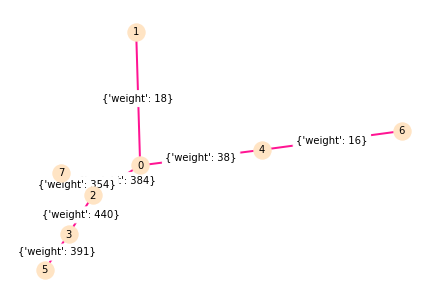

Neighbors of node 0: ['1', '4', '2']
Neighbors of node 1: ['0']
Neighbors of node 2: ['7', '0', '3']
Neighbors of node 3: ['5', '2']
Neighbors of node 4: ['6', '0']
Neighbors of node 5: ['3']
Neighbors of node 6: ['4']
Neighbors of node 7: ['2']
{'6': '4', '0': '4', '1': '0', '2': '0', '7': '2', '3': '2', '5': '3'}
Here come your alignment pairs and the idex dict: 

{'6': '4', '0': '4', '1': '0', '2': '0', '7': '2', '3': '2', '5': '3'}
{'4': '0', '6': '1', '0': '2', '1': '3', '2': '4', '7': '5', '3': '6', '5': '7'}
this is the key: 6 and this is the value: 4

 now aligning....atggatttatctgctcttcgcgttgaagaagtacaaaatgtcattaacgctatgcagaaaatcttagagtgtcccatctgtctggagttgatcaaggaacctgtctccacaaagtgtgaccacatattttgcaaattttgcatgctgaaacttctcaaccagaagaaagggccttcacagtgtcctttatgtaagaatga and atggatttatctgctgttcgcgttgaagaagtacaaaatgtcattaatgctatgcagaaaatcttagagtgtccaatctgtctggagttgatcaaggaacctgtctccacaaagtgtgaccacatattttgcagattttgcatgctgaaacttctcaaccagaagaaagggccttcacagtgtcctttgtgtaagaatga
Alignments:

In [4]:
#running it!! (not ruining it hopefully :P )

gap_cost=5
cost, M, matrix_for_MST, G =new_sp_approxi_combi(brca_seqs_work_please,score_matrix,gap_cost, verbose=True)


[['' '1' '1' '2']
 ['' '1' '1' '3']
 ['' '2' '1' '4']
 ['' '5' '2' '3']
 ['' '5' '3' '4']
 ['' '6' '2' '4']]
[['*' '1' '1' '2']
 ['*' '1' '1' '3']
 ['*' '2' '1' '4']
 ['' '5' '2' '3']
 ['' '5' '3' '4']
 ['' '6' '2' '4']]


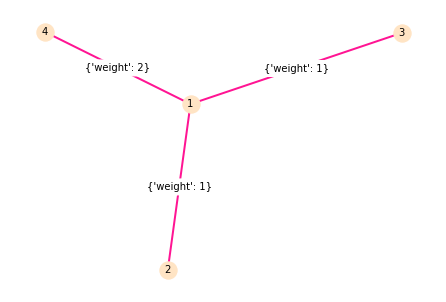

In [5]:
has_obvious_center_string=np.array([['','1','1','2'],['','1','1','3'],['','2','1','4'],['','5','2','3'],['','5','3','4'],['','6','2','4']])
print(has_obvious_center_string)

min_sp_ed=find_min_span_edges_testing(has_obvious_center_string)
print(min_sp_ed)
graphy=fill_graph(min_sp_ed,'1')


In [6]:
import timeit
has_obvious_center_string=np.array([['','1','1','2'],['','1','1','3'],['','2','1','4'],['','5','2','3'],['','5','3','4'],['','6','2','4']])
print(has_obvious_center_string)

timeit.timeit(find_min_span_edges_testing(np.array([['','1','1','2'],['','1','1','3'],['','2','1','4'],['','5','2','3'],['','5','3','4'],['','6','2','4']])))



[['' '1' '1' '2']
 ['' '1' '1' '3']
 ['' '2' '1' '4']
 ['' '5' '2' '3']
 ['' '5' '3' '4']
 ['' '6' '2' '4']]


ValueError: stmt is neither a string nor callable